<a href="https://colab.research.google.com/github/aruaru0/pytorch-classifier-sample/blob/main/pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm
!pip install icrawler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00


In [ ]:
import torch
import timm
import numpy as np
from icrawler.builtin import GoogleImageCrawler

# 画像を取得する

In [ ]:
google_crawler = GoogleImageCrawler(
    storage={'root_dir': 'images/dog'})
google_crawler.crawl(keyword='dog', max_num=100)

ERROR:downloader:Response status code 400, file https://www.thesprucepets.com/thmb/hxWjs7evF2hP1Fb1c1HAvRi_Rw0\u003d/2765x0/filters:no_upscale():strip_icc()/chinese-dog-breeds-4797219-hero-2a1e9c5ed2c54d00aef75b05c5db399c.jpg
ERROR:downloader:Response status code 404, file https://www.scotsman.com/webimg/b25lY21zOjdlNGNiYTJjLWRhMTAtNGJhYS04N2U2LWRiM2U1MjQ0ZDkzYjoxM2U0Y2FkMi1jYzc0LTQ0ZTYtYjc5My02ZDg5Y2MwOGMzZjY\u003d.jpg
ERROR:downloader:Response status code 404, file https://www.scotsman.com/webimg/b25lY21zOjdjODA4MjQzLWMyNDktNDkxOS1hYzBlLTI0NDg2YmVhMjliZTpkMmQ1OGE0ZS0xNDAzLTQxZTAtYTBlMi1lY2I2ZDVhOTdhMDA\u003d.jpg
ERROR:downloader:Response status code 400, file https://www.dailypaws.com/thmb/S6Iaa-eEk-2mUcuox_BV1oWbyVc\u003d/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/neapolitan-mastiff-with-woman-on-leash-2-77685259-2000-81fba6fbcb8244d2adb24e31cc082c78.jpg
ERROR:downloader:Exception caught when downloading file https://www.nylabone.com/-/media/project/oneweb/nylabone/im

In [ ]:
google_crawler = GoogleImageCrawler(
    storage={'root_dir': 'images/cat'})
google_crawler.crawl(keyword='cat', max_num=100)

ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg
ERROR:downloader:Response status code 400, file https://www.thesprucepets.com/thmb/uQnGtOt9VQiML2oG2YzAmPErrHo\u003d/5441x0/filters:no_upscale():strip_icc()/all-about-tabby-cats-552489-hero-a23a9118af8c477b914a0a1570d4f787.jpg
ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg
ERROR:downloader:Response status code 401, file https://i.guim.co.uk/img/media/26392d05302e02f7bf4eb143bb84c8097d09144b/446_167_3683_2210/master/3683.jpg
ERROR:downloader:Response status code 400, file https://th-thumbnailer.cdn-si-edu.com/bZAar59Bdm95b057iESytYmmAjI\u003d/1400x1050/filters:focal(594x274:595x275)/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/95/db/95db799b-fddf-4fde-91f3-77024442b92d/egypt_kitty_social.jpg
ERROR:downloader:Response status code 400, file https://cdn.theatlantic.com/thumbor/

In [ ]:
!mkdir images/train images/valid images/train/cat images/train/dog images/valid/cat images/valid/dog
!mv images/cat/00000?.jpg images/valid/cat
!mv images/dog/00000?.jpg images/valid/dog
!mv images/cat images/train
!mv images/dog images/train

# データローダ・データセットの作成

In [ ]:
from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform

In [ ]:
dataset_train = create_dataset('train', root="./images/train", class_map={'dog':0, 'cat':1})#, transform=create_transform(224))
dataset_valid = create_dataset('valid', root="./images/valid", class_map={'dog':0, 'cat':1})

1

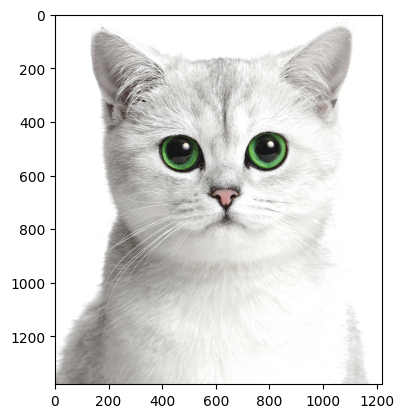

In [ ]:
import matplotlib.pyplot as plt
img, label = dataset_train[0]
plt.imshow(img)
label

In [ ]:
dataloader_train = create_loader(dataset_train, input_size=(3,224,224), batch_size=16, is_training=True)
dataloader_valid = create_loader(dataset_valid, input_size=(3,224,224), batch_size=8, is_training=False)

In [ ]:
# 確認
for X, y in dataloader_valid:
  print(y)

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0], device='cuda:0')


# モデル作成

In [ ]:
model = timm.create_model('resnet18', pretrained=True, num_classes=2)

# パラメータ設定

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 学習

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)

for epoch in range(num_epochs):
    print("EPOCH", epoch)
    model.train()
    train_loss = 0
    for batch in tqdm(dataloader_train):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        loss = loss_fn(outputs, targets)
        train_loss += float(loss.detach().cpu())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    for batch in tqdm(dataloader_valid):
        inputs, targets = batch
        with torch.no_grad() :
          outputs = model(inputs.to(device))
        loss = loss_fn(outputs, targets)
        eval_loss += float(loss.detach().cpu())
    print("train_loss = ", train_loss, "eval_loss = ", eval_loss)


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


train_loss =  1.1167783811688423 eval_loss =  0.4039292838424444


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


train_loss =  0.5723501332104206 eval_loss =  0.41185062751173973


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


train_loss =  0.6922728978097439 eval_loss =  0.7120563965290785


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


train_loss =  0.7401753179728985 eval_loss =  0.92754543479532


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


train_loss =  0.9908472895622253 eval_loss =  0.4353695623940439


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


train_loss =  0.6257322318851948 eval_loss =  0.24966044233588036


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


train_loss =  0.418641384691 eval_loss =  0.18047677652793936


100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


train_loss =  0.34284356608986855 eval_loss =  0.13574806920951232


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


train_loss =  0.3922074921429157 eval_loss =  0.359973566402914


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

train_loss =  1.2926445379853249 eval_loss =  0.6829960844479501


# 評価

In [ ]:
model.eval()
y_pred = []
y_gt = []
for batch in tqdm(dataloader_valid):
    inputs, targets = batch
    with torch.no_grad() :
      outputs = model(inputs.to(device))
    y_gt += targets.tolist()
    y_pred += outputs.argmax(axis=1).tolist()


100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


In [ ]:
y_pred, y_gt

([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# 指標の計算

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

In [ ]:
confusion_matrix(y_gt, y_pred)

array([[8, 1],
       [0, 8]])

In [ ]:
acc, recall, fs = accuracy_score(y_gt, y_pred), recall_score(y_gt, y_pred), f1_score(y_gt, y_pred)
print(f"acc={acc}, recall={recall}. f-score={fs}")

acc=0.9411764705882353, recall=1.0. f-score=0.9411764705882353


# ミス画像の表示

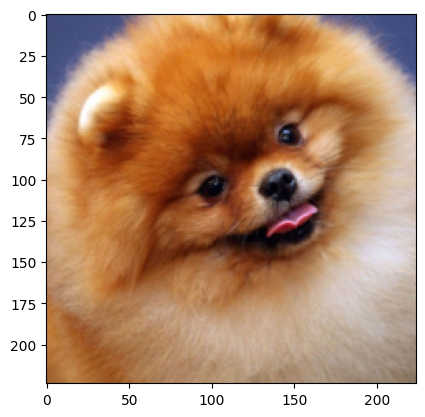

In [64]:
for idx, (x, y) in enumerate(zip(y_pred, y_gt)):
  if x != y :
    img, label = dataset_valid[idx]
    plt.imshow(img.transpose(1,2,0))
    plt.show()